### Introduction 

Birth weight is the birth of an infant taken right after birth (Typically on the first hour). Low birth weight is defined by the World Health Organization (WHO) as birth weight of under 2500 g (Not including 2500). Infants with low birth weight are 20 times more at risk of dying than infants with birth weights above this threshold (Cutland, 2017). Given the importance of this measurement, being able to correctly predict low birth weights is critical. The purpose of this work is to create a classification model using the birthweight.csv data to correctly predict low birth weight on the samples. The code is divided in sections such as data exploration, feature engineering, modeling and analysis. At the end the best model out of the three created will be selected as the final model and used to make the final predictions. 

<b> First Steps <b>

In [3]:
#Importing libraries
import numpy as np                                              #Math essetianls
import pandas as pd                                             #Data science essentials
import matplotlib.pyplot as plt                                 #Data viz
import seaborn as sns                                           #Enhance data viz
import phik                                                     #Phi matrix and coefficient
import statsmodels.formula.api as smf                           #Logistic regression
from sklearn.metrics import (confusion_matrix,
    roc_auc_score, precision_score, recall_score, make_scorer)  #Score calculations
from sklearn.model_selection import train_test_split            #Splitting data
import sklearn.linear_model                                     #Linear models
from sklearn.ensemble import RandomForestClassifier             #RF Classifier
from sklearn.preprocessing import StandardScaler                #Scaling data     
from sklearn.model_selection import RandomizedSearchCV          #Randomized search, for hypertunning
from sklearn.ensemble import GradientBoostingClassifier         #GB Classifier


#Setting up the path to the train data
file = "/Users/juanmanumango/Desktop/Hult/Intro to machine learning and AI/Assignments/A2_Modeling Case Study/Data/birthweight.csv"

#Reading the file
df_train = pd.read_csv(file)

#Setting up the path to the kaggle data
file = "/Users/juanmanumango/Desktop/Hult/Intro to machine learning and AI/Assignments/A2_Modeling Case Study/Data/kaggle_test_data.csv"

#Reading the file
df_test = pd.read_csv(file)


#Setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

#Checking data
df_train.head(n = 5)

,bwt_id,mage,meduc,monpre,npvis,fage,feduc,omaps,fmaps,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght
0,bwt_1,28,12.0,2,10.0,31.0,17.0,8.0,9.0,0.0,0.0,0,1,0,0,1,0,0,3317
1,bwt_2,21,NaN,1,6.0,21.0,NaN,8.0,9.0,NaN,NaN,0,1,0,0,1,0,0,1160
2,bwt_3,27,15.0,2,11.0,32.0,16.0,9.0,9.0,0.0,0.0,1,1,0,0,1,0,0,4706
3,bwt_4,33,17.0,1,20.0,39.0,17.0,9.0,10.0,0.0,0.0,0,0,0,1,0,0,1,3289
4,bwt_5,30,15.0,2,12.0,36.0,16.0,9.0,9.0,NaN,NaN,1,1,0,0,1,0,0,3490


In [6]:
#Creating 'set' columns in both datasets to differentiate them when concatenating
df_train['set'] = 'Not Kaggle'
df_test['set'] = 'Kaggle'

#Concatenating train and kaggle datasets together
df_full = pd.concat(objs         = [df_train, df_test],
                    axis         = 0,
                    ignore_index = False)

#Checking results
df_full.head(n = 5)

,bwt_id,mage,meduc,monpre,npvis,fage,feduc,omaps,fmaps,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set
0,bwt_1,28,12.0,2,10.0,31.0,17.0,8.0,9.0,0.0,0.0,0,1,0,0,1,0,0,3317.0,Not Kaggle
1,bwt_2,21,NaN,1,6.0,21.0,NaN,8.0,9.0,NaN,NaN,0,1,0,0,1,0,0,1160.0,Not Kaggle
2,bwt_3,27,15.0,2,11.0,32.0,16.0,9.0,9.0,0.0,0.0,1,1,0,0,1,0,0,4706.0,Not Kaggle
3,bwt_4,33,17.0,1,20.0,39.0,17.0,9.0,10.0,0.0,0.0,0,0,0,1,0,0,1,3289.0,Not Kaggle
4,bwt_5,30,15.0,2,12.0,36.0,16.0,9.0,9.0,NaN,NaN,1,1,0,0,1,0,0,3490.0,Not Kaggle


<b> User defined function <b>
    

In [7]:
#########################
# mv_flagger
#########################
def mv_flagger(df):
    """
Flags all columns that have missing values with 'm-COLUMN_NAME'.

PARAMETERS
----------
df : DataFrame to flag missing values


RETURNS
-------
DataFrame with missing value flags."""


    for col in df:

        if df[col].isnull().astype(int).sum() > 0:
            df['m_'+col] = df[col].isnull().astype(int)
            
    return df



#########################
# text_split_feature
#########################
def text_split_feature(col, df, sep=' ', new_col_name='number_of_names'):
    """
Splits values in a string Series (as part of a DataFrame) and sums the number
of resulting items. Automatically appends summed column to original DataFrame.

PARAMETERS
----------
col          : column to split
df           : DataFrame where column is located
sep          : string sequence to split by, default ' '
new_col_name : name of new column after summing split, default
               'number_of_names'
"""
    
    df[new_col_name] = 0
    
    
    for index, val in df.iterrows():
        df.loc[index, new_col_name] = len(df.loc[index, col].split(sep = ' '))

########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # number of features to plot
    n_features = train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('./analysis_images/Feature_Importance.png')
        
#########################
#categorize 
#########################
def categorize(col, a, b, c = None):
    
    """
    Creates groups inside the column depending on the specified values 
    
    PARAMETERS
    ----------
    col : Column to categorize
    a   : First limit for grouping
    b   : Second limit for grouping
    c   : Third limit for grouping, default None
    """
    
    #If the value in col is smaller than a return 1
    if col < a:
        return 1
    #Elif the value in col is in between a and b return 2
    elif a <= col < b:
        return 2
    #Elif c is specified and col between b and c return 3, if not skip
    elif c is not None and b <= col < c:
        return 3
    #Else return 4
    else:
         return 4
    
#########################
#avg_missing_value 
#########################
def avg_missing_value(df, target, by):
    """
    Groups the data by the "by" column and fills missing values with the average of each group of values
    
    PARAMETERS
    ----------
    df     : The data frame 
    target : The column with missing values
    by     : The column you want to group the data by
    """
    
    #Calculating the average target for each by group
    avg_values = df_full.groupby(by)[target].mean().round(decimals = 0)
    
    #If value is missing
    if pd.isna(df[target]):
        
        #If it is return the average target for that by group
        return avg_values.get(df[by], df[target]).round(0)
    
    else:
        #If value is not missing return the original value
        return df[target]
    
#########################
#avg_value 
#########################
def avg_value(df, target, by, new_col = 'new_col'):
    """
    Groups the data by the "by" column and classifies values in "target" using the "by" groups quantiles
    
    PARAMETERS
    ----------
    df      : The data frame 
    target  : The column with missing values
    by      : The column you want to group the data by
    new_col : The name of the results column, default "new_col"
    """
        
    #Calculates the first and third quantiles after grouping "by"
    Q1 = df.groupby(by)[target].quantile(0.25)
    Q3 = df.groupby(by)[target].quantile(0.75)

    #Creating temporary columns with the quantile values for each row
    df['target_Q1_group'] = df[by].map(Q1)
    df['target_Q3_group'] = df[by].map(Q3)
    
    #Defining an inner function that compares the "target" value to it's quantiles and classifies
    def quartile_group(row):
        if row[target] < row['target_Q1_group']:
            return 1
        elif row[target] > row['target_Q3_group']:
            return 3
        else:
            return 2

    #Applies the inner fucntion to all rows
    df[new_col] = df.apply(quartile_group, axis=1)
    
    #Drop temporary columns
    df = df.drop(columns=['target_Q1_group', 'target_Q3_group'], inplace = True)
    
    #Return 'df' after changes
    return df

<b> Data Exploration <b>

In [8]:
#Dropping post-event horizon features
df_full = df_full.drop(labels = ['omaps','fmaps'],
                       axis   = 1)


#Checking results
df_full.columns

Index(['bwt_id', 'mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'bwght', 'set'], dtype='object')

In [9]:
#Checking column types
df_full.dtypes    

bwt_id     object
mage        int64
meduc     float64
monpre      int64
npvis     float64
fage      float64
feduc     float64
cigs      float64
drink     float64
male        int64
mwhte       int64
mblck       int64
moth        int64
fwhte       int64
fblck       int64
foth        int64
bwght     float64
set        object
dtype: object

In [10]:
#Exploring missing values
df_full.isnull().sum()

bwt_id     0
mage       0
meduc      6
monpre     0
npvis     21
fage       1
feduc     10
cigs      33
drink     32
male       0
mwhte      0
mblck      0
moth       0
fwhte      0
fblck      0
foth       0
bwght     64
set        0
dtype: int64

In [11]:
#Checking how big is the data
df_full.shape

(473, 18)

In [7]:
# creating feature sets
continuous     = ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'bwght']

# pearson correlation
df_corr = df_train[ continuous ].corr(method = 'pearson').round(decimals = 4)


# checking results
print(f"""
Point-Biserial Correlations
---------------------------
{df_corr.loc[ : , 'bwght' ].sort_values(ascending = False)}
""")


Point-Biserial Correlations
---------------------------
bwght     1.0000
npvis     0.1806
fage      0.1388
feduc     0.0605
monpre    0.0551
mage      0.0546
meduc     0.0013
Name: bwght, dtype: float64



After calculating the linear correlations (using Pearson's method) of the continuous original variables ('mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc') with low_birth_weight we can conclude that there are no strong correlations, positive or negative. The 'strongest' being npvis, which has a  correlation of 0.18. This is not a strong correlation by any means but seeing this is also not surprising. The most clear indicators of low birth weight such as premature birth and mother' weight and nutrition are not present in the data (Boston Children's Hospital). The data available by itself does not contribute significantly to the prediction of low birth weight and therefore feature engineering is required to extract the value from the data.

In [6]:
#Applying the mv_flagger function to the data
mv_flagger(df_full)

,bwt_id,mage,meduc,monpre,npvis,fage,feduc,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set,m_meduc,m_npvis,m_fage,m_feduc,m_cigs,m_drink,m_bwght
0,bwt_1,28,12.0,2,10.0,31.0,17.0,0.0,0.0,0,1,0,0,1,0,0,3317.0,Not Kaggle,0,0,0,0,0,0,0
1,bwt_2,21,NaN,1,6.0,21.0,NaN,NaN,NaN,0,1,0,0,1,0,0,1160.0,Not Kaggle,1,0,0,1,1,1,0
2,bwt_3,27,15.0,2,11.0,32.0,16.0,0.0,0.0,1,1,0,0,1,0,0,4706.0,Not Kaggle,0,0,0,0,0,0,0
3,bwt_4,33,17.0,1,20.0,39.0,17.0,0.0,0.0,0,0,0,1,0,0,1,3289.0,Not Kaggle,0,0,0,0,0,0,0
4,bwt_5,30,15.0,2,12.0,36.0,16.0,NaN,NaN,1,1,0,0,1,0,0,3490.0,Not Kaggle,0,0,0,0,1,1,0
5,bwt_6,29,16.0,1,12.0,32.0,16.0,0.0,0.0,0,1,0,0,1,0,0,3345.0,Not Kaggle,0,0,0,0,0,0,0
6,bwt_7,31,12.0,2,12.0,31.0,12.0,0.0,0.0,0,1,0,0,1,0,0,3030.0,Not Kaggle,0,0,0,0,0,0,0
7,bwt_8,28,12.0,1,13.0,31.0,14.0,0.0,0.0,0,1,0,0,1,0,0,3771.0,Not Kaggle,0,0,0,0,0,0,0
8,bwt_9,24,12.0,2,15.0,25.0,12.0,0.0,0.0,1,1,0,0,1,0,0,1660.0,Not Kaggle,0,0,0,0,0,0,0
9,bwt_10,28,16.0,1,12.0,32.0,12.0,0.0,0.0,0,1,0,0,1,0,0,1786.0,Not Kaggle,0,0,0,0,0,0,0


<b> Strategies for missing value imputation and feature engineering <b>

In [ ]:
#Strategies

#mage  (continious)  - One-hot encoding age groups
#fage  (continious)  - Missing values average depending on the fage. One-hot encoding age groups
#meduc (continious)  - Missing value using average depending on mage. One-hot encoding by educ groups for their age groups
#feduc (continious)  - Missing value using average depending on fage. One-hot encoding by educ groups for their age groups
#monpre(categorical) - One-hot encoding early, mid, late
#npvis (continious)  - Missing value average of monpre. One-hot encode on avg for monpre, low, avg and above.

#cigs and drink (continious) - missing values to 0. Making them binary
#mwhite... (categorical)     - combine into the different m/f pairs



<b> Missing Value Imputation <b>

In [10]:
#Grouping the data for missing value imputation

#Applying categorize function on mage, fage and monpre to create group columns
df_full['mage_group'] = df_full['mage'].apply(categorize, args = (20, 30, 40))
df_full['fage_group'] = df_full['fage'].apply(categorize, args = (20, 30, 40))
df_full['monpre_group'] = df_full['monpre'].apply(categorize, args = (3, 6))

#Checking results
df_full.head(n = 5)

,bwt_id,mage,meduc,monpre,npvis,fage,feduc,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set,m_meduc,m_npvis,m_fage,m_feduc,m_cigs,m_drink,m_bwght,mage_group,fage_group,monpre_group
0,bwt_1,28,12.0,2,10.0,31.0,17.0,0.0,0.0,0,1,0,0,1,0,0,3317.0,Not Kaggle,0,0,0,0,0,0,0,2,3,1
1,bwt_2,21,NaN,1,6.0,21.0,NaN,NaN,NaN,0,1,0,0,1,0,0,1160.0,Not Kaggle,1,0,0,1,1,1,0,2,2,1
2,bwt_3,27,15.0,2,11.0,32.0,16.0,0.0,0.0,1,1,0,0,1,0,0,4706.0,Not Kaggle,0,0,0,0,0,0,0,2,3,1
3,bwt_4,33,17.0,1,20.0,39.0,17.0,0.0,0.0,0,0,0,1,0,0,1,3289.0,Not Kaggle,0,0,0,0,0,0,0,3,3,1
4,bwt_5,30,15.0,2,12.0,36.0,16.0,NaN,NaN,1,1,0,0,1,0,0,3490.0,Not Kaggle,0,0,0,0,1,1,0,3,3,1


These three features were mostly created to support the creation of other features such as npvis_group, and to impute missing values in the data.

In [11]:

#Applying the avg_missing_value function to the 'meduc' column
df_full['meduc'] = df_full.apply(avg_missing_value, axis=1, args = ('meduc','mage_group'))

#Making sure all missing values for meduc are taken care of
print(f"Remaining missing values for npvis: {df_full.loc[ :, 'meduc'].isnull().sum()}")



Remaining missing values for npvis: 0


In [12]:
#Applying the avg_missing_value function to the 'npvis' column
df_full['npvis'] = df_full.apply(avg_missing_value, axis=1, args = ('npvis','monpre_group'))

#Making sure all missing values for npvis are taken care of
print(f"Remaining missing values for npvis: {df_full.loc[ :, 'npvis'].isnull().sum()}")



Remaining missing values for npvis: 0


In [13]:
#Applying the avg_missing_value function to the 'fage' column
df_full['fage'] = df_full.apply(avg_missing_value, axis=1, args = ('fage','mage'))

#Making sure all missing values for fage are taken care of
print(f"Remaining missing values for fage: {df_full.loc[ :, 'fage'].isnull().sum()}")

df_full.head(5)

Remaining missing values for fage: 0


,bwt_id,mage,meduc,monpre,npvis,fage,feduc,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set,m_meduc,m_npvis,m_fage,m_feduc,m_cigs,m_drink,m_bwght,mage_group,fage_group,monpre_group
0,bwt_1,28,12.0,2,10.0,31.0,17.0,0.0,0.0,0,1,0,0,1,0,0,3317.0,Not Kaggle,0,0,0,0,0,0,0,2,3,1
1,bwt_2,21,13.0,1,6.0,21.0,NaN,NaN,NaN,0,1,0,0,1,0,0,1160.0,Not Kaggle,1,0,0,1,1,1,0,2,2,1
2,bwt_3,27,15.0,2,11.0,32.0,16.0,0.0,0.0,1,1,0,0,1,0,0,4706.0,Not Kaggle,0,0,0,0,0,0,0,2,3,1
3,bwt_4,33,17.0,1,20.0,39.0,17.0,0.0,0.0,0,0,0,1,0,0,1,3289.0,Not Kaggle,0,0,0,0,0,0,0,3,3,1
4,bwt_5,30,15.0,2,12.0,36.0,16.0,NaN,NaN,1,1,0,0,1,0,0,3490.0,Not Kaggle,0,0,0,0,1,1,0,3,3,1


In [14]:
#Applying the avg_missing_value function to the 'fage' column
df_full['feduc'] = df_full.apply(avg_missing_value, axis=1, args = ('feduc','fage_group'))

#Making sure all missing values for fage are taken care of
print(f"Remaining missing values for feduc: {df_full.loc[ :, 'feduc'].isnull().sum()}")

df_full.head(5)

Remaining missing values for feduc: 0


,bwt_id,mage,meduc,monpre,npvis,fage,feduc,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set,m_meduc,m_npvis,m_fage,m_feduc,m_cigs,m_drink,m_bwght,mage_group,fage_group,monpre_group
0,bwt_1,28,12.0,2,10.0,31.0,17.0,0.0,0.0,0,1,0,0,1,0,0,3317.0,Not Kaggle,0,0,0,0,0,0,0,2,3,1
1,bwt_2,21,13.0,1,6.0,21.0,13.0,NaN,NaN,0,1,0,0,1,0,0,1160.0,Not Kaggle,1,0,0,1,1,1,0,2,2,1
2,bwt_3,27,15.0,2,11.0,32.0,16.0,0.0,0.0,1,1,0,0,1,0,0,4706.0,Not Kaggle,0,0,0,0,0,0,0,2,3,1
3,bwt_4,33,17.0,1,20.0,39.0,17.0,0.0,0.0,0,0,0,1,0,0,1,3289.0,Not Kaggle,0,0,0,0,0,0,0,3,3,1
4,bwt_5,30,15.0,2,12.0,36.0,16.0,NaN,NaN,1,1,0,0,1,0,0,3490.0,Not Kaggle,0,0,0,0,1,1,0,3,3,1


In [15]:
#Imputating missing values in the cigs column with 0
df_full['cigs'] = df_full['cigs'].fillna(value = 0)

#Imputating missing values in the drink column with 0
df_full['drink'] = df_full['drink'].fillna(value = 0)

print(f"""
Remaining missing values for cigs: {df_full.loc[ :, 'cigs'].isnull().sum()}
Remaining missing values for drink: {df_full.loc[ :, 'drink'].isnull().sum()}
""")


Remaining missing values for cigs: 0
Remaining missing values for drink: 0



<b> Feature Engineering <b>

In [16]:
#Adding a column that classifies between low and normal bwght
df_full['low_birth_weight'] = (df_full['bwght'] <= 2499).astype(int)

#Checking results
df_full.head(n = 5)

,bwt_id,mage,meduc,monpre,npvis,fage,feduc,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set,m_meduc,m_npvis,m_fage,m_feduc,m_cigs,m_drink,m_bwght,mage_group,fage_group,monpre_group,low_birth_weight
0,bwt_1,28,12.0,2,10.0,31.0,17.0,0.0,0.0,0,1,0,0,1,0,0,3317.0,Not Kaggle,0,0,0,0,0,0,0,2,3,1,0
1,bwt_2,21,13.0,1,6.0,21.0,13.0,0.0,0.0,0,1,0,0,1,0,0,1160.0,Not Kaggle,1,0,0,1,1,1,0,2,2,1,1
2,bwt_3,27,15.0,2,11.0,32.0,16.0,0.0,0.0,1,1,0,0,1,0,0,4706.0,Not Kaggle,0,0,0,0,0,0,0,2,3,1,0
3,bwt_4,33,17.0,1,20.0,39.0,17.0,0.0,0.0,0,0,0,1,0,0,1,3289.0,Not Kaggle,0,0,0,0,0,0,0,3,3,1,0
4,bwt_5,30,15.0,2,12.0,36.0,16.0,0.0,0.0,1,1,0,0,1,0,0,3490.0,Not Kaggle,0,0,0,0,1,1,0,3,3,1,0


Feature that classifies the bwght column as 1 if < 2500 and 0 if >= 2500. This feature is essential for the creation of a classification model.

In [17]:

#Applying the avg_value function on meduc,feduc and nvis 
avg_value(df_full, 'meduc', 'mage_group', 'meduc_group')
avg_value(df_full, 'feduc', 'fage_group', 'feduc_group')
avg_value(df_full, 'npvis', 'monpre_group', 'npvis_group')

#Checking results
df_full.head()

,bwt_id,mage,meduc,monpre,npvis,fage,feduc,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set,m_meduc,m_npvis,m_fage,m_feduc,m_cigs,m_drink,m_bwght,mage_group,fage_group,monpre_group,low_birth_weight,meduc_group,feduc_group,npvis_group
0,bwt_1,28,12.0,2,10.0,31.0,17.0,0.0,0.0,0,1,0,0,1,0,0,3317.0,Not Kaggle,0,0,0,0,0,0,0,2,3,1,0,2,3,2
1,bwt_2,21,13.0,1,6.0,21.0,13.0,0.0,0.0,0,1,0,0,1,0,0,1160.0,Not Kaggle,1,0,0,1,1,1,0,2,2,1,1,2,2,1
2,bwt_3,27,15.0,2,11.0,32.0,16.0,0.0,0.0,1,1,0,0,1,0,0,4706.0,Not Kaggle,0,0,0,0,0,0,0,2,3,1,0,2,2,2
3,bwt_4,33,17.0,1,20.0,39.0,17.0,0.0,0.0,0,0,0,1,0,0,1,3289.0,Not Kaggle,0,0,0,0,0,0,0,3,3,1,0,3,3,3
4,bwt_5,30,15.0,2,12.0,36.0,16.0,0.0,0.0,1,1,0,0,1,0,0,3490.0,Not Kaggle,0,0,0,0,1,1,0,3,3,1,0,2,2,2


meduc_group and feduc_group were created using the averages of their corresponding mage and fage. npvis_group was created by comparing the sample npvis to the lower and higher quantiles of their corresponding monpre_group. This were later one hot encoded before being introduced into the model. The aim of this features is to compare the education level and npvis to what other's in the same group and circumstances had, to identify outliers and special cases. 

In [18]:
#Binary classification for the cigs and drink columns
df_full['smoker'] = (df_full['cigs'] > 0).astype(int)
df_full['drinker'] = (df_full['drink'] > 0).astype(int)

#Checking results
df_full.head(n = 5)

,bwt_id,mage,meduc,monpre,npvis,fage,feduc,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set,m_meduc,m_npvis,m_fage,m_feduc,m_cigs,m_drink,m_bwght,mage_group,fage_group,monpre_group,low_birth_weight,meduc_group,feduc_group,npvis_group,smoker,drinker
0,bwt_1,28,12.0,2,10.0,31.0,17.0,0.0,0.0,0,1,0,0,1,0,0,3317.0,Not Kaggle,0,0,0,0,0,0,0,2,3,1,0,2,3,2,0,0
1,bwt_2,21,13.0,1,6.0,21.0,13.0,0.0,0.0,0,1,0,0,1,0,0,1160.0,Not Kaggle,1,0,0,1,1,1,0,2,2,1,1,2,2,1,0,0
2,bwt_3,27,15.0,2,11.0,32.0,16.0,0.0,0.0,1,1,0,0,1,0,0,4706.0,Not Kaggle,0,0,0,0,0,0,0,2,3,1,0,2,2,2,0,0
3,bwt_4,33,17.0,1,20.0,39.0,17.0,0.0,0.0,0,0,0,1,0,0,1,3289.0,Not Kaggle,0,0,0,0,0,0,0,3,3,1,0,3,3,3,0,0
4,bwt_5,30,15.0,2,12.0,36.0,16.0,0.0,0.0,1,1,0,0,1,0,0,3490.0,Not Kaggle,0,0,0,0,1,1,0,3,3,1,0,2,2,2,0,0


smoker and drinker features are just binary features that determine whether the mother smoked or drank during pregnancy, the aim of this feature is to reduce noise in the data under the assumption that drinking or smoking, no matter the amount, is prejudicial to the fetus's health. 


In [19]:
#Engineering features for the possible combinations of parent races 

#Black mom and Black dad
df_full['bm/bf'] = ((df_full['mblck'] > 0) & (df_full['fblck'] > 0)).astype(int)

#Black mom and White dad
df_full['bm/wf'] = ((df_full['mblck'] > 0) & (df_full['fwhte'] > 0)).astype(int)

#Black mom and Other dad
df_full['bm/of'] = ((df_full['mblck'] > 0) & (df_full['foth'] > 0)).astype(int)

#White mom and Black dad
df_full['wm/bf'] = ((df_full['mwhte'] > 0) & (df_full['fblck'] > 0)).astype(int)

#White mom and Other dad
df_full['wm/of'] = ((df_full['mwhte'] > 0) & (df_full['foth'] > 0)).astype(int)

#Other mom and Black dad
df_full['om/bf'] = ((df_full['moth'] > 0) & (df_full['fblck'] > 0)).astype(int)

#Other mom and White dad
df_full['om/wf'] = ((df_full['moth'] > 0) & (df_full['fwhte'] > 0)).astype(int)

#Other mom and Other dad
df_full['om/of'] = ((df_full['moth'] > 0) & (df_full['foth'] > 0)).astype(int)

#White mom and White dad
df_full['wm/wf'] = ((df_full['mwhte'] > 0) & (df_full['fwhte'] > 0)).astype(int)

#Checking results
df_full.head()

,bwt_id,mage,meduc,monpre,npvis,fage,feduc,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set,m_meduc,m_npvis,m_fage,m_feduc,m_cigs,m_drink,m_bwght,mage_group,fage_group,monpre_group,low_birth_weight,meduc_group,feduc_group,npvis_group,smoker,drinker,bm/bf,bm/wf,bm/of,wm/bf,wm/of,om/bf,om/wf,om/of,wm/wf
0,bwt_1,28,12.0,2,10.0,31.0,17.0,0.0,0.0,0,1,0,0,1,0,0,3317.0,Not Kaggle,0,0,0,0,0,0,0,2,3,1,0,2,3,2,0,0,0,0,0,0,0,0,0,0,1
1,bwt_2,21,13.0,1,6.0,21.0,13.0,0.0,0.0,0,1,0,0,1,0,0,1160.0,Not Kaggle,1,0,0,1,1,1,0,2,2,1,1,2,2,1,0,0,0,0,0,0,0,0,0,0,1
2,bwt_3,27,15.0,2,11.0,32.0,16.0,0.0,0.0,1,1,0,0,1,0,0,4706.0,Not Kaggle,0,0,0,0,0,0,0,2,3,1,0,2,2,2,0,0,0,0,0,0,0,0,0,0,1
3,bwt_4,33,17.0,1,20.0,39.0,17.0,0.0,0.0,0,0,0,1,0,0,1,3289.0,Not Kaggle,0,0,0,0,0,0,0,3,3,1,0,3,3,3,0,0,0,0,0,0,0,0,0,1,0
4,bwt_5,30,15.0,2,12.0,36.0,16.0,0.0,0.0,1,1,0,0,1,0,0,3490.0,Not Kaggle,0,0,0,0,1,1,0,3,3,1,0,2,2,2,0,0,0,0,0,0,0,0,0,0,1


Racial categorical features had very little significance in the model, by combining them to form the different pairs, the assumption was that it would give more insight on the situation of the fetus.

In [20]:
#One got encoding group features created previously
one_hot_mage = pd.get_dummies(data = df_full['mage_group'], prefix = 'mage', dtype = int)        #Mage
one_hot_fage = pd.get_dummies(data = df_full['fage_group'], prefix = 'fage', dtype = int)        #Fage
one_hot_feduc = pd.get_dummies(data = df_full['feduc_group'], prefix = 'feduc', dtype = int)     #Feduc
one_hot_meduc = pd.get_dummies(data = df_full['meduc_group'], prefix = 'meduc', dtype = int)     #Meduc
one_hot_monpre = pd.get_dummies(data = df_full['monpre_group'], prefix = 'monpre', dtype = int)  #Monpre
one_hot_npvis = pd.get_dummies(data = df_full['npvis_group'], prefix = 'npvis', dtype = int)     #Npvis

#Concatenating the new features to df_full
df_full = pd.concat([df_full, one_hot_mage, one_hot_fage, one_hot_feduc, one_hot_meduc, one_hot_monpre, one_hot_npvis], axis = 1)


#Checking results
df_full.columns

Index(['bwt_id', 'mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'bwght', 'set', 'm_meduc', 'm_npvis', 'm_fage', 'm_feduc', 'm_cigs', 'm_drink', 'm_bwght', 'mage_group', 'fage_group', 'monpre_group', 'low_birth_weight', 'meduc_group', 'feduc_group', 'npvis_group', 'smoker', 'drinker', 'bm/bf', 'bm/wf', 'bm/of', 'wm/bf', 'wm/of', 'om/bf', 'om/wf', 'om/of', 'wm/wf', 'mage_1', 'mage_2', 'mage_3', 'mage_4', 'fage_1', 'fage_2', 'fage_3', 'fage_4', 'feduc_1', 'feduc_2', 'feduc_3', 'meduc_1', 'meduc_2', 'meduc_3', 'monpre_1', 'monpre_2', 'monpre_4', 'npvis_1', 'npvis_2', 'npvis_3'], dtype='object')

In [21]:
#Renaming columns
df_full.columns = [
'bwt_id', 'mage', 'meduc', 'monpre', 'npvis', 'fage', 
'feduc', 'cigs', 'drink', 'male', 'mwhte', 'mblck', 'moth', 
'fwhte', 'fblck', 'foth', 'bwght', 'set', 'm_meduc', 'm_npvis', 
'm_fage', 'm_feduc', 'm_cigs', 'm_drink', 'm_bwght', 'mage_group', 
'fage_group', 'monpre_group', 'low_birth_weight', 'meduc_group', 
'feduc_group', 'npvis_group', 'smoker', 'drinker', 'bmbf', 'bmwf', 
'bmof', 'wmbf', 'wmof', 'ombf', 'omwf', 'omof', 'wmwf', 
'teen_mom', 'tnts_mom', 'trts_mom', 'grandma', 'teen_dad', 
'tnts_dad', 'trts_dad', 'grandad', 'low_ed_f', 'nrml_ed_f', 'hgh_ed_f', 'low_ed_m', 'nrml_ed_m', 
'hgh_ed_m', 'erly_strt', 'nrml_strt', 'lt_strt', 'low_npvis', 'nrml_npvis', 'high_npvis']

#Checking results
df_full.head(n = 5)

,bwt_id,mage,meduc,monpre,npvis,fage,feduc,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set,m_meduc,m_npvis,m_fage,m_feduc,m_cigs,m_drink,m_bwght,mage_group,fage_group,monpre_group,low_birth_weight,meduc_group,feduc_group,npvis_group,smoker,drinker,bmbf,bmwf,bmof,wmbf,wmof,ombf,omwf,omof,wmwf,teen_mom,tnts_mom,trts_mom,grandma,teen_dad,tnts_dad,trts_dad,grandad,low_ed_f,nrml_ed_f,hgh_ed_f,low_ed_m,nrml_ed_m,hgh_ed_m,erly_strt,nrml_strt,lt_strt,low_npvis,nrml_npvis,high_npvis
0,bwt_1,28,12.0,2,10.0,31.0,17.0,0.0,0.0,0,1,0,0,1,0,0,3317.0,Not Kaggle,0,0,0,0,0,0,0,2,3,1,0,2,3,2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0
1,bwt_2,21,13.0,1,6.0,21.0,13.0,0.0,0.0,0,1,0,0,1,0,0,1160.0,Not Kaggle,1,0,0,1,1,1,0,2,2,1,1,2,2,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0
2,bwt_3,27,15.0,2,11.0,32.0,16.0,0.0,0.0,1,1,0,0,1,0,0,4706.0,Not Kaggle,0,0,0,0,0,0,0,2,3,1,0,2,2,2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0
3,bwt_4,33,17.0,1,20.0,39.0,17.0,0.0,0.0,0,0,0,1,0,0,1,3289.0,Not Kaggle,0,0,0,0,0,0,0,3,3,1,0,3,3,3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1
4,bwt_5,30,15.0,2,12.0,36.0,16.0,0.0,0.0,1,1,0,0,1,0,0,3490.0,Not Kaggle,0,0,0,0,1,1,0,3,3,1,0,2,2,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0


<b> Preparing for Modeling <b>

In [22]:
## parsing out testing data (needed for later) ##

# dataset for kaggle
kaggle_data = df_full[ df_full['set'] == 'Kaggle' ].copy()


# dataset for model building
df = df_full[ df_full['set'] == 'Not Kaggle' ].copy()


# dropping set identifier (kaggle)
kaggle_data.drop(labels = 'set',
                 axis = 1,
                 inplace = True)


# dropping set identifier (model building)
df.drop(labels = 'set',
        axis = 1,
        inplace = True)

In [23]:
# creating feature sets
continuous     = ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'bwght']

non_continuous = ['mage_group', 
'fage_group', 'monpre_group', 'low_birth_weight', 'meduc_group', 
'feduc_group', 'npvis_group', 'smoker', 'drinker', 'bmbf', 'bmwf', 
'bmof', 'wmbf', 'wmof', 'ombf', 'omwf', 'omof', 'wmwf', 'teen_mom', 
'tnts_mom', 'trts_mom', 'grandma', 'teen_dad', 'tnts_dad', 'trts_dad', 
'grandad', 'low_ed_f', 'nrml_ed_f', 'hgh_ed_f', 'low_ed_m', 'nrml_ed_m', 
'hgh_ed_m', 'erly_strt', 'nrml_strt', 'lt_strt', 'low_npvis', 'nrml_npvis', 
'high_npvis']


# pearson correlation
df_corr = df[ continuous ].corr(method = 'pearson').round(decimals = 4)


# phi coefficient
df_phi_corr = df[ non_continuous ].phik_matrix(interval_cols = non_continuous).round(decimals = 4)


# checking results
print(f"""
Point-Biserial Correlations
---------------------------
{df_corr.loc[ : , 'bwght' ].sort_values(ascending = False)}


Phi Coefficients
----------------
{df_phi_corr.loc[ : , 'low_birth_weight' ].sort_values(ascending = False)}
""")

/Users/juanmanumango/anaconda3/lib/python3.11/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable bmof for analysis 1. Dropping this column
  warnings.warn(
/Users/juanmanumango/anaconda3/lib/python3.11/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable ombf for analysis 1. Dropping this column
  warnings.warn(



Point-Biserial Correlations
---------------------------
bwght     1.0000
npvis     0.1768
fage      0.1415
feduc     0.0626
monpre    0.0551
mage      0.0546
meduc     0.0037
Name: bwght, dtype: float64


Phi Coefficients
----------------
low_birth_weight    1.0000
low_npvis           0.3016
nrml_npvis          0.1647
fage_group          0.1624
nrml_ed_m           0.1491
mage_group          0.1305
npvis_group         0.1194
teen_mom            0.1107
low_ed_m            0.0757
teen_dad            0.0686
grandad             0.0664
hgh_ed_m            0.0661
meduc_group         0.0569
tnts_dad            0.0526
erly_strt           0.0000
nrml_strt           0.0000
hgh_ed_f            0.0000
nrml_ed_f           0.0000
low_ed_f            0.0000
lt_strt             0.0000
trts_dad            0.0000
trts_mom            0.0000
grandma             0.0000
tnts_mom            0.0000
wmwf                0.0000
omof                0.0000
omwf                0.0000
wmof                0.0000
wmbf

<u><b> Modeling <b><u>

In [24]:
# train/test split with the full model

#Defining the x features for the final model
final_model_features = ['smoker', 'bmbf', 'omof', 'wmwf', 
'teen_mom', 'tnts_mom', 'trts_mom', 
'tnts_dad', 'grandad', 'low_ed_f', 'hgh_ed_f', 'nrml_ed_m', 
'hgh_ed_m', 'erly_strt', 'lt_strt', 'low_npvis',  'high_npvis']

#Defining the y_variable
y_variable = 'low_birth_weight'

#Setting up the variables and features for the model
bw_data   =  df[final_model_features]
bw_target =  df[y_variable]


#Usin train test split to split the data for modeling
x_train, x_test, y_train, y_test = train_test_split(
            bw_data,
            bw_target,
            random_state = 702,
            test_size    = 0.30,
            stratify     = bw_target)

In [ ]:
##LINEAR REGRESSION MODEL##

#Instantiating a linear regression model
model = sklearn.linear_model.LogisticRegression(solver = 'lbfgs',
                                                 C = 1,
                                                 random_state = 702)


In [ ]:
# ##HYPERPARAMETER TUNNING FOR RANDOM FOREST##

# #Instantiating a hyperparameter space
# n_estimators      = np.arange(100, 300, 50)
# criterion         = ['gini','entropy','log_loss']
# max_depth         = [None, 5, 10]
# min_samples_leaf  = np.arange(1 ,11, 2)
# bootstrap         = [True, False]
# warm_start        = [True, False]
# max_samples       = np.arange(1, 5, 1)
# min_samples_split = np.arange(1, 5, 1)

# #Creating a hyperparameter grid
# param_grid = {'n_estimators'      : n_estimators,
#               'criterion'         : criterion,
#               'max_depth'         : max_depth,
#               'min_samples_leaf'  : min_samples_leaf,
#               'bootstrap'         : bootstrap,
#               'warm_start'        : warm_start,
#               'max_samples'       : max_samples,
#               'min_samples_split' : min_samples_split}

# #Instantiating the model object without hyperparameters
# forest_grid = RandomForestClassifier(random_state = 702)

# #GridSearchCV object
# forest_cv = RandomizedSearchCV(estimator           = forest_grid,
#                                param_distributions = param_grid,
#                                cv                  = 3,
#                                n_iter              = 500,
#                                scoring             = make_scorer(roc_auc_score,
#                                                      needs_threshold = False))

# #Fitting to the full data set 
# forest_cv.fit(bw_data, bw_target)

# #Printing the best parameters and score
# print("Tuned Parameters  :", forest_cv.best_params_)
# print("Tuned Training AUC:", forest_cv.best_score_.round(decimals = 4))


In [ ]:
##RANDOM FOREST CLASSIFIER##

model = RandomForestClassifier(random_state = 702)#, **forest_cv.best_params_) #(This should be uncommented if using RFC)

In [ ]:
# ##HYPERPARAMETER TUNNING FOR GRADIENT BOOSTING##

# #Instantiating a hyperparameter space
# loss             = ['log_loss', 'exponential']
# n_estimators     = np.arange(100, 300, 50)
# criterion        = ['friedman_mse', 'squared_error']
# learning_rate    = np.arange(0.1,0.5,0.1)
# max_depth        = [None, 5, 10]
# min_samples_leaf = np.arange(1 ,11, 2)
# min_samples_split = np.arange(1, 5, 1)

# #Creating a hyperparameter grid
# param_grid = {'loss'              : loss,
#               'n_estimators'      : n_estimators,
#               'criterion'         : criterion,
#               'learning_rate'     : learning_rate,
#               'max_depth'         : max_depth,
#               'min_samples_leaf'  : min_samples_leaf,
#               'min_samples_split' : min_samples_split}

# #Instantiating the model object without hyperparameters
# full_gbm_grid = GradientBoostingClassifier(random_state = 702)

# #GridSearchCV object
# full_gbm_cv = RandomizedSearchCV(estimator     = full_gbm_grid,
#                            param_distributions = param_grid,
#                            cv                  = 3,
#                            n_iter              = 500,
#                            random_state        = 702,
#                            scoring             = make_scorer(roc_auc_score,
#                                                  needs_threshold = False))

# #Fitting to the full data set 
# full_gbm_cv.fit(bw_data, bw_target)

# #Printing the best parameters and score
# print("Tuned Parameters  :", full_gbm_cv.best_params_)
# print("Tuned Training AUC:", full_gbm_cv.best_score_.round(4))


In [ ]:
##GRADIENT BOOSTING CLASSIFIER##

model = GradientBoostingClassifier(random_state  = 702)#, **full_gbm_cv.best_params_) #(This should be uncommented if using RFC)

### Modeling 

In [25]:
##GRADIENT BOOSTING CLASSIFIER##

model = GradientBoostingClassifier(random_state  = 702, 
                                   n_estimators = 150, 
                                   min_samples_split = 3, 
                                   min_samples_leaf = 5, 
                                   max_depth = 5, 
                                   loss = 'log_loss', 
                                   learning_rate = 0.1, 
                                   criterion = 'squared_error')


In [26]:
# FITTING the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING based on the testing set
model_pred = model.predict(x_test)

# saving scoring data for future use
train_score = round(model_fit.score(x_train, y_train), ndigits = 4) # train accuracy
test_score  = round(model_fit.score(x_test, y_test),   ndigits = 4) # test accuracy
tt_gap      = round(abs(train_score - test_score),      ndigits = 4) # gap

# displaying and saving the gap between training and testing
print(f"""\
Training ACCURACY: {train_score}
Testing  ACCURACY: {test_score}
Train-Test Gap   : {tt_gap}
""") 

Training ACCURACY: 0.8776
Testing  ACCURACY: 0.748
Train-Test Gap   : 0.1296



<b> Model Insights <b>

In [27]:
#Unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()


#Printing each result one-by-one
print(f"""
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


True Negatives : 89
False Positives: 10
False Negatives: 21
True Positives : 3



In [28]:
#Preparing AUC, precision, and recall
auc       = round(roc_auc_score(y_true = y_test, y_score = model_pred) , ndigits = 4)
precision = round(precision_score(y_true = y_test, y_pred = model_pred), ndigits = 4)
recall    = round(recall_score(y_true = y_test, y_pred = model_pred)   , ndigits = 4)


#Dynamically printing metrics
print(f"""\
AUC:       {auc}
Precision: {precision}
Recall:    {recall}
""")

AUC:       0.512
Precision: 0.2308
Recall:    0.125



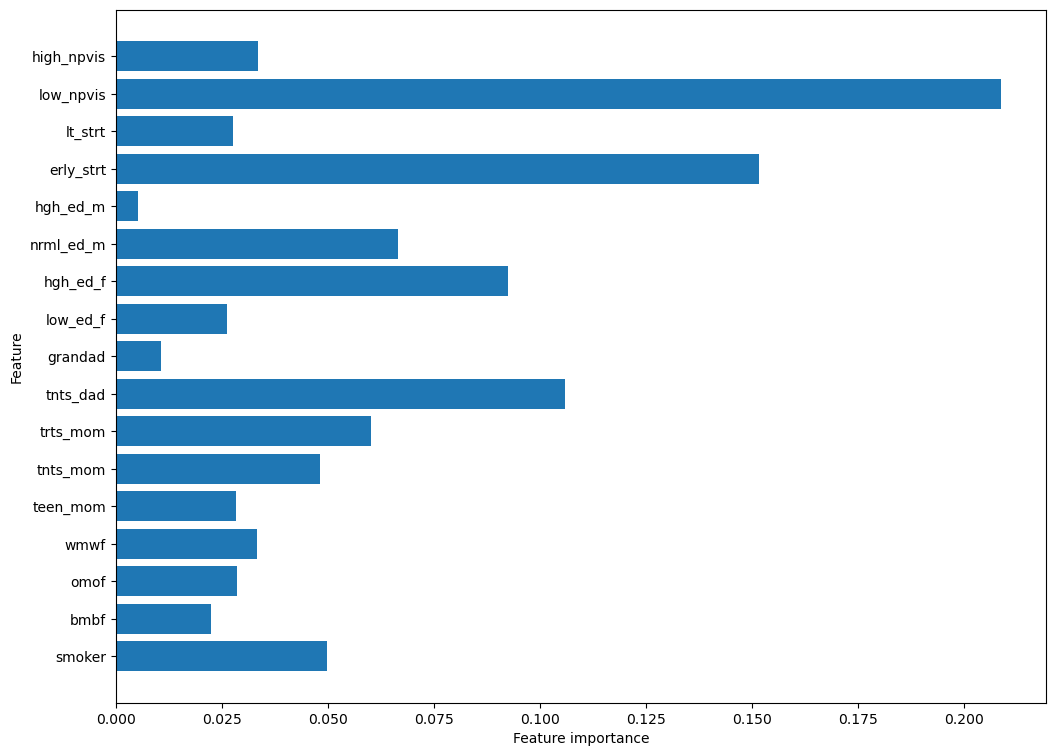

In [29]:
#Plotting feature importance using plot_feature_importances function
plot_feature_importances(model = model_fit, train = x_train)

The bar plot above shows the feature importance of each feature that went into the model. This plot was used to determine which features to keep in the model and which to take out. For example, drinker and wmof were taken out from the model given their insignificant importance to the model. On the other hand, the plot helps to show the features that truly add value to the model such as low_npvis and erly_strt. This graphs also helped me come up with features that combined multiple original features, with the purpose of incrementing their added value to the model. 

<b> Class Probability Analysis <b>

In [30]:
#Printing the predicted probabilities of 0 and 1, respectively
classes = pd.DataFrame(data = model_fit.predict_proba(bw_data).round(decimals = 1),
             columns = ['Class 0', 'Class 1'])


In [31]:

#Merging the probabilities to the df 
result = pd.merge(classes, df, left_index=True, right_index=True, how='left') 

#Dividing the data bewteen low and high birth weight
result_low = result[result['low_birth_weight'] == 1]
result_high = result[result['low_birth_weight'] == 0]

#Subsetting the class probability for True positives and True negatives
low_val_count = pd.DataFrame(result_low['Class 1'].astype(str).value_counts())
high_val_count =  pd.DataFrame(result_high['Class 1'].astype(str).value_counts())

#Dynamically printing results
print(f"""True: 
{low_val_count.sort_values('Class 1')}
False:
{high_val_count.sort_values('Class 1')}""")

True: 
         count
Class 1       
0.0          5
0.1          8
0.2         24
0.3         10
0.4          2
0.5          8
0.6          1
0.7          5
0.8          8
0.9          8
1.0          1
False:
         count
Class 1       
0.0        111
0.1         95
0.2         78
0.3         21
0.4          6
0.5         12
0.7          2
0.9          4


In [32]:
#Adjusting the class probability
result['pred_thresh_'] = (result['Class 1'] >= 0.6).astype(dtype = int)

In [33]:
#Unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = result['low_birth_weight'], y_pred = result['pred_thresh_']).ravel()


#Printing each result one-by-one
print(f"""
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


True Negatives : 323
False Positives: 6
False Negatives: 57
True Positives : 23



In [34]:
#Printing the precision for the adjusted classes results
print(f"""
precision: {model_tp/(model_tp + model_fp)}
""")


precision: 0.7931034482758621



<b> KAGGLE <b>

In [35]:
#x_features
x_data_kaggle = kaggle_data[final_model_features].copy()

#Fitting model from above to the Kaggle test data
kaggle_predictions = model.predict(x_data_kaggle)

#Printing the predicted probabilities of 0 and 1, respectively
kaggle_classes = pd.DataFrame(data = model.predict_proba(x_data_kaggle).round(decimals = 2),
             columns = ['Class 0', 'Class 1'])

#Adjusting class probability
kaggle_classes['pred_thresh'] = (kaggle_classes['Class 1'] >= 0.60).astype(dtype = int)

#Merging to add bwt_id
kaggle_classes = pd.merge(kaggle_classes, kaggle_data, left_index=True, right_index=True)

In [36]:
#Organizing predictions
model_predictions = {"bwt_id"    : kaggle_classes['bwt_id'],
                     "low_bwght" : kaggle_classes['pred_thresh']}


#Converting predictions into df
model_pred_df = pd.DataFrame(data  = model_predictions)

In [37]:
#Naming the cvs file with the Kaggle results
model_pred_df.to_csv(path_or_buf = "/Users/juanmanumango/Desktop/Hult/Intro to machine learning and AI/Assignments/A2_Modeling Case Study/Model_output/Final.csv",
                     index       = False)

### Analysis

<b> Linear Relations with base data: <b>

After calculating the linear correlations (using Pearson's method) of the continuous original variables ('mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc') with low_birth_weight we can conclude that there are no strong correlations, positive or negative. The 'strongest' being npvis, which has a  correlation of 0.18. This is not a strong correlation by any means but seeing this is also not surprising. The most clear indicators of low birth weight such as premature birth and mother' weight and nutrition are not present in the data (Boston Children's Hospital). The data available by itself does not contribute significantly to the prediction of low birth weight and therefore feature engineering is required to extract the value from the data.

<b> Thresholds for calculating low birth weight.  <b>

There are three official thresholds, the first and most important being the < 2500 g that determine whether the infant has Low Birth Weight (LBW). The second one at < 1500 g, that classifies the infant as having Very Low Birth Weight (VLBW). Lastly if the infant is < 1000 g is then classified as Extremely Low Birth Weight (ELBW). Just being classified as having LBW can make the infant 20+ times more likely to die. The primary cause being premature birth. (Cutland, 2017)



<b> Most impactful features on the model <b>

The two most important features in the model were low_npvis and erly_strt. Low_npvis is a feature that captures the amount of prenatal visits taking into account in which month the prenatal care started. Having low_npvis true in the model signals that the baby was growing up nicely and special care was not needed. On the other high_npvis would signify that there might be something wrong with the baby and special care was needed. erly_strt signifies that the prenatal care started before the third month of gestation. This would signify that the couple was probably expecting or trying to get pregnant, which would result in a better care plan for the fetus growth and therefore lower the chances of the baby being born with LBW. 

<b> Post-model Analysis <b>

* Confusion Matrix: 

- True Negatives : 323
- False Positives: 6
- False Negatives: 57
- True Positives : 23

False positive values represent the instances in which the model predicted a low_birth_weight incorrectly. On the other hand false negative represent the occasions in which the model predicted a healthy birth weight when in fact it was low_birth_weight. In this assignment, the error being controlled is false positives, that being instances were the model predicted a low birth weight when in fact the baby was healthy. In my opinion, contrary to the focus of the cohort, false negatives are more critical in this study. Predicting that a baby will be born healthy when in fact it was born with LBW is more critical than incorrectly predicting an infant will have LBW. If the model predicted a LBW but the baby was growing without any issues, the worst thing that could happen is a small increase in medical expenses. On the other hand, predicting a normal birth weight when in fact the baby was going to be born with LBW makes that infant 20 times more likely to die. Given that a life weights more than an increase in medical expenses, the focus of the cohort should have been on lowering the amount of false negatives. 

<b> References <b>

1. Cutland, C. L., Lackritz, E. M., Mallett-Moore, T., Bardají, A., Chandrasekaran, R., Lahariya, C., Nisar, M. I., Tapia, M. D., Pathirana, J., Kochhar, S., Muñoz, F. M., & Brighton Collaboration Low Birth Weight Working Group (2017). Low birth weight: Case definition & guidelines for data collection, analysis, and presentation of maternal immunization safety data. Vaccine, 35(48 Pt A), 6492–6500. https://doi.org/10.1016/j.vaccine.2017.01.049

2. Boston Children Hospital, Low Birthweight in Newborns, https://www.childrenshospital.org/conditions/low-birthweight-newborns

<b> Additional Late Submission Model <b>

Because the competition ended at 5pm and I'm not completely sure if we could still upload models being able to see the outcome in the private leaderboard I'm uploading this model as an extra, given that my private leaderboard score for my final model was 0 :)


In [38]:
#Features used in the extra final model
features = ['mage', 'meduc', 'monpre', 'npvis', 'fage', 
'feduc', 'smoker', 'male','bmbf', 'omof', 'wmwf']

Turns out the features I engineered extracted very little value from the data, and I got better results in the private leaderboard with the original features + some of the engineered ones.

In [39]:
#Defining the y_variable
y_variable = 'low_birth_weight'

#Setting up the variables and features for the model
bw_data   =  df[features]
bw_target =  df[y_variable]


#Usin train test split to split the data for modeling
x_train, x_test, y_train, y_test = train_test_split(
            bw_data,
            bw_target,
            random_state = 702,
            test_size    = 0.30,
            stratify     = bw_target)

In [40]:
##GRADIENT BOOSTING CLASSIFIER##

model = GradientBoostingClassifier(random_state      = 702, 
                                   n_estimators      = 100, 
                                   min_samples_split = 4, 
                                   min_samples_leaf  = 1, 
                                   max_depth         = 5, 
                                   loss              = 'log_loss', 
                                   learning_rate     = 0.30000000000000004, 
                                   criterion         = 'friedman_mse')

In [41]:
# FITTING the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING based on the testing set
model_pred = model.predict(x_test)

# saving scoring data for future use
train_score = round(model_fit.score(x_train, y_train), ndigits = 4) # train accuracy
test_score  = round(model_fit.score(x_test, y_test),   ndigits = 4) # test accuracy
tt_gap      = round(abs(train_score - test_score),      ndigits = 4) # gap

# displaying and saving the gap between training and testing#x_features
x_data_kaggle = kaggle_data[features].copy()

#Fitting model from above to the Kaggle test data
kaggle_predictions = model.predict(x_data_kaggle)

#Printing the predicted probabilities of 0 and 1, respectively
kaggle_classes = pd.DataFrame(data = model.predict_proba(x_data_kaggle).round(decimals = 2),
             columns = ['Class 0', 'Class 1'])

#Adjusting class probability
kaggle_classes['pred_thresh'] = (kaggle_classes['Class 1'] >= 0.50).astype(dtype = int)

#Merging to add bwt_id
kaggle_classes = pd.merge(kaggle_classes, kaggle_data, left_index=True, right_index=True)
print(f"""\
Training ACCURACY: {train_score}
Testing  ACCURACY: {test_score}
Train-Test Gap   : {tt_gap}
""") 

Training ACCURACY: 0.9965
Testing  ACCURACY: 0.6992
Train-Test Gap   : 0.2973



In [42]:
#Organizing predictions
model_predictions = {"bwt_id"    : kaggle_classes['bwt_id'],
                     "low_bwght" : kaggle_classes['pred_thresh']}


#Converting predictions into df
model_pred_df = pd.DataFrame(data  = model_predictions)

In [ ]:
#Naming the cvs file with the Kaggle results
model_pred_df.to_csv(path_or_buf = "/Users/juanmanumango/Desktop/Hult/Intro to machine learning and AI/Assignments/A2_Modeling Case Study/Model_output/LateSubmissionFinal.csv",
                     index       = False)